In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
from sklearn.metrics import *
import seaborn as sns

In [2]:
wordvec = open("x_train_TITLES.p","r")
data  = pkl.load(wordvec)

In [3]:
data = np.array(data)
y = open("y_train_TITLES.p","r")
labels = pkl.load(y)
labels = np.array(labels)

In [4]:
test_file = open("x_test_TITLES.p","r")
test_data = pkl.load(test_file)

y_test = open("y_test_TITLES.p","r")
test_labels = pkl.load(y_test)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

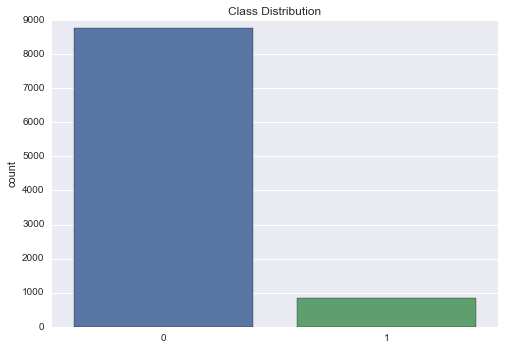

In [5]:
sns.countplot(labels)
plt.title("Class Distribution")

In [6]:
# Data Preprocessing

# Oversampling the data to remove class imbalance problem

unq, unq_idx = np.unique(labels, return_inverse=True)
unq_cnt = np.bincount(unq_idx)
cnt = np.max(unq_cnt)
new_labels = np.empty((cnt*len(unq),) + labels.shape[1:], labels.dtype)
new_data = np.empty((cnt*len(unq),) + data.shape[1:], data.dtype)
for j in xrange(len(unq)):
    indices = np.random.choice(np.where(unq_idx==j)[0], cnt)
    new_labels[j*cnt:(j+1)*cnt] = labels[indices]
    new_data[j*cnt:(j+1)*cnt] = data[indices]

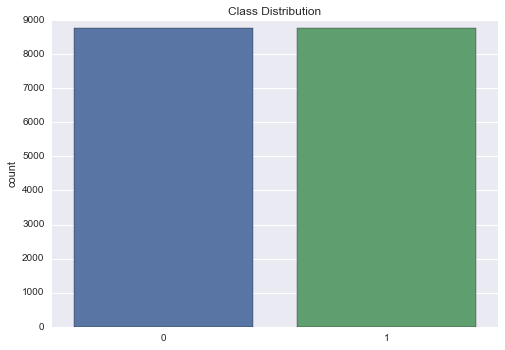

In [7]:
sns.countplot(new_labels)
plt.title("Class Distribution")

In [8]:
maxIter = 1000
batch_size = 200
learningRate = 0.001

In [9]:
def mlp(input_data):
    
    w1 = tf.get_variable("w0",[data.shape[1], 20], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b0",[20], initializer=tf.constant_initializer(0.0))
    w2 = tf.get_variable("w1",[20, 15], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b1",[15], initializer=tf.constant_initializer(0.0))
    w3 = tf.get_variable("w2",[15, 2], initializer=tf.random_normal_initializer())
    b3 = tf.get_variable("b2",[2], initializer=tf.constant_initializer(0.0))
    
    fc1 = tf.nn.relu(tf.add(tf.matmul(input_data,w1),b1))
    fc2 = tf.nn.relu(tf.add(tf.matmul(fc1,w2),b2))
    fc3 = tf.nn.relu(tf.add(tf.matmul(fc2,w3),b3))
    
    weights = [w1,b1,w2,b2,w3,b3]
    
    return fc3, weights
    
    

In [10]:
X = tf.placeholder("float", [None, data.shape[1]])
Y = tf.placeholder("float", [None, 2])

pred, weights = mlp(X)
loss = tf.nn.softmax_cross_entropy_with_logits(pred, Y)
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss)



In [11]:
# One Hot Encoding
def one_hot(labels):
    new_labels = []
    for i in labels:
        temp = np.zeros(2)
        temp[i] = 1
        new_labels.append(temp)

    new_labels = np.array(new_labels)
    return new_labels

In [12]:
new_labels = one_hot(new_labels)
test_labels = one_hot(test_labels)

In [13]:
test_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [14]:
right_pred = tf.equal(tf.argmax(Y,1),tf.argmax(pred,1))
accuracy = tf.reduce_mean(tf.cast(right_pred, tf.float32))



In [13]:
num_batch = data.shape[0]/batch_size + 1

with tf.Session() as sess:
    
    tf.initialize_all_variables().run()
    
    for it in range(maxIter):
        for i in range(num_batch):            
            
            start = i*batch_size
            if (i == num_batch-1):
                end = data.shape[0]
            else:
                end = (i+1)*batch_size
            
            input_data = data[start:end]
            
            label = new_labels[start:end]
            
            sess.run([loss,optimizer], feed_dict={X: input_data, Y: label})
            
        
            
            
        if it % 2 == 0:
            train_Accuracy = accuracy.eval(feed_dict={X: input_data, Y: label})

            print('step {0}, training accuracy {1}'.format(it, train_Accuracy))            

step 0, training accuracy 0.565217375755
step 2, training accuracy 0.739130437374
step 4, training accuracy 0.826086938381
step 6, training accuracy 0.826086938381
step 8, training accuracy 0.826086938381
step 10, training accuracy 0.826086938381
step 12, training accuracy 0.826086938381
step 14, training accuracy 0.826086938381
step 16, training accuracy 0.826086938381
step 18, training accuracy 0.826086938381
step 20, training accuracy 0.826086938381
step 22, training accuracy 0.826086938381
step 24, training accuracy 0.826086938381
step 26, training accuracy 0.826086938381
step 28, training accuracy 0.826086938381
step 30, training accuracy 0.826086938381
step 32, training accuracy 0.826086938381
step 34, training accuracy 0.826086938381
step 36, training accuracy 0.826086938381
step 38, training accuracy 0.826086938381
step 40, training accuracy 0.826086938381
step 42, training accuracy 0.826086938381
step 44, training accuracy 0.826086938381
step 46, training accuracy 0.8260869383

KeyboardInterrupt: 

In [15]:


with tf.Session() as sess1:
    
    tf.initialize_all_variables().run()
    
    for i in range(maxIter+1):
        
        sess1.run(optimizer, feed_dict={X: new_data, Y: new_labels})
        
        if i%100 == 0:
            train_Accuracy = accuracy.eval(feed_dict={X: test_data, Y: test_labels})

            print('step {0}, training accuracy {1} '.format(i, train_Accuracy))    

    y_p = tf.argmax(pred, 1)
    val_accuracy, y_pred = sess1.run([accuracy, y_p], feed_dict={X: test_data, Y: test_labels})

    print "validation accuracy:", val_accuracy
    y_true = np.argmax(test_labels,1)
    print "Precision", precision_score(y_true, y_pred)
    print "Recall", recall_score(y_true, y_pred)
    print "f1_score", f1_score(y_true, y_pred)
    print "confusion_matrix"
    print confusion_matrix(y_true, y_pred)
    fpr, tpr, tresholds = roc_curve(y_true, y_pred)


        

step 0, training accuracy 0.565008580685 
step 100, training accuracy 0.784219563007 
step 200, training accuracy 0.840137243271 
step 300, training accuracy 0.857289850712 
step 400, training accuracy 0.867581486702 
step 500, training accuracy 0.871698141098 
step 600, training accuracy 0.875128626823 
step 700, training accuracy 0.880274415016 
step 800, training accuracy 0.881646633148 
step 900, training accuracy 0.882332742214 
step 1000, training accuracy 0.88267582655 
validation accuracy: 0.882676
Precision 0.475
Recall 0.345454545455
f1_score 0.4
confusion_matrix
[[2459  126]
 [ 216  114]]


In [16]:
tp = sum[]

array([ 2585.,   330.])

In [24]:
2459.0/(2459+216)

0.9192523364485982

In [18]:
sum(y_pred)

240

In [19]:
2585/2915.0

0.8867924528301887